## 数据处理

#### 数据加载

* 实现自定义的数据集需要继承Dataset，并实现`__getitem()__`和`__len__`方法。

* `__getitem__`:返回一条数据或一个样本，`obj[index]`等价于`obj.__getitem__(index)`

* `__len__`:返回样本的数量。`len(obj)等价于obj.__len__()`。

In [36]:
%env LS_COLORS = None
!tree --charset ascii  data/dogcat/

env: LS_COLORS=None
参数太多 - ascii


In [37]:
import torch as t
from torch.utils import data

In [38]:
import os
from PIL import Image
import numpy as np

In [39]:
class DogCat(data.Dataset):
    def __init__(self,root):
        imgs = os.listdir(root)
        
        #所有图片的绝对路径，调用__getitem__时，才真正读图片
        self.imgs = [os.path.join(root,img) for img in imgs]
        
    def __getitem__(self,index):
        img_path = self.imgs[index]
        # dog -> 1, cat -> 0
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data,label
    
    def __len__(self):
        return len(self.imgs)

In [40]:
dataset = DogCat('./data/dogcat/')
img,label = dataset[0]
for img,label in  dataset:
    print(img.size(),img.float().mean(),label)

torch.Size([500, 497, 3]) tensor(106.4915) 0
torch.Size([499, 379, 3]) tensor(171.8085) 0
torch.Size([236, 289, 3]) tensor(130.3004) 0
torch.Size([374, 499, 3]) tensor(115.5177) 0
torch.Size([375, 499, 3]) tensor(116.8138) 1
torch.Size([375, 499, 3]) tensor(150.5079) 1
torch.Size([377, 499, 3]) tensor(151.7174) 1
torch.Size([400, 300, 3]) tensor(128.1550) 1


`Resize`:调整图片尺寸

`CenterCrop、RandomCrop、RandomSizedCrop`:裁剪图片

`Pad`：填充

`ToTensor`：将PIL Image对象转成Tensor，会自动将[0,255]归一化至[0,1]。

In [41]:
from torchvision import transforms as T
import numpy as np

In [42]:
transform = T.Compose([
    T.Resize(224), # 缩放图片
    T.CenterCrop(224), # 将图片从中切出224 * 224的图片
    T.ToTensor(), # 将图片转成Tensor，归一化至[0,1]
    T.Normalize(mean=[.5,.5,.5],std = [.5,.5,.5])# 标准化至[-1,1]
])

In [43]:
class DogCat(data.Dataset):
    def __init__(self,root,transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root,img) for img in imgs]
        self.transforms = transforms
        
    def __getitem__(self,index):
        img_path = self.imgs[index]
        label = 0 if 'dog' in img_path.split('/')[-1] else 1
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
            
        return data,label
    
    def __len__(self):
        return len(self,imgs)
    
dataset = DogCat('./data/dogcat/',transforms=transform)
img,label = dataset[0]
for img,label in dataset:
    print(img.size(),label)

torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0


In [44]:
!tree --charset ASCII data/dogcat_2/

参数太多 - ASCII


In [45]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder('data/dogcat_2/')

In [46]:
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [47]:
#所有图片的路径和label
dataset.imgs

[('data/dogcat_2/cat\\cat.12484.jpg', 0),
 ('data/dogcat_2/cat\\cat.12485.jpg', 0),
 ('data/dogcat_2/cat\\cat.12486.jpg', 0),
 ('data/dogcat_2/cat\\cat.12487.jpg', 0),
 ('data/dogcat_2/dog\\dog.12496.jpg', 1),
 ('data/dogcat_2/dog\\dog.12497.jpg', 1),
 ('data/dogcat_2/dog\\dog.12498.jpg', 1),
 ('data/dogcat_2/dog\\dog.12499.jpg', 1)]

In [48]:
dataset[0][1]# 一维是第几张图，二维为1返回label

0

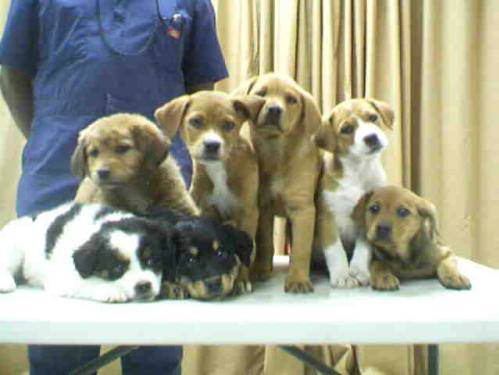

In [49]:
dataset[5][0]# 一维是第几张图，二维为0返回图片

In [50]:
normalize = T.Normalize(mean=[0.4,0.4,0.4],std = [0.2,0.2,0.2])
transform = T.Compose([
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

In [51]:
dataset = ImageFolder('data/dogcat_2/',transform=transform)

In [52]:
dataset[0][0].size()# 通道数 * 高 * 宽

torch.Size([3, 224, 224])

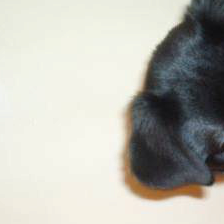

In [53]:
to_img = T.ToPILImage()
to_img(dataset[6][0] * 0.2 + 0.4)# 0.2是标准差，0.4是均值

```python
DataLoader（dateset,batch_size=1,shuffle=False,sampler=None,num_workers=0,collate_fn=default_collate,pin_memory=False,drop+last=False）
```

`dataset`：加载的数据集

`batch_size`：每次加载的大小

`shuffle`：是否将数据打乱

`sampler`：样本抽样

`num_workers`：使用多进程加载的进程数，0代表不使用多进程

`pin_memory`：是否将数据保存在pin memory区

`collate_fn`：一般使用默认拼接方式

`drop_last`：将不足一个batch的数据丢弃

In [54]:
from torch.utils.data import DataLoader

In [55]:
dataloader = DataLoader(dataset=dataset,batch_size=3,shuffle=True,num_workers=0,drop_last=False)
dataiter = iter(dataloader)
img,labels = next(dataiter)
img.size()

torch.Size([3, 3, 224, 224])

dataloader是一个可迭代对象

In [58]:
# for batch_datas,batch_labels in dataloader:
#     train()
# 或者
# dataiter = iter(dataloader)
# batch_datas,batch_labels = next(dataiter)

In [59]:
class NewDogCat(DogCat):
    def __getitem__(self,index):
        try:
            return super(NewDogCat,self).__getitem__(index)
        except:
            return None,None

In [60]:
from torch.utils.data.dataloader import default_collate

def my_collate_fn(batch):
    '''
    batch每个元素形如(data,label)
    '''
    # 过滤为None的数据
    batch = list(filter(lambda x : x[0] is not None,batch))
    return default_collate(batch)

In [61]:
dataset = NewDogCat('data/dogcat_wrong/',transforms=transform)

In [62]:
dataset[5]

(tensor([[[-0.8431, -0.8627, -0.8824,  ...,  1.0196,  0.7647,  0.6471],
          [-0.8627, -0.9216, -0.9412,  ...,  1.1569,  0.8235,  0.6471],
          [-0.8235, -0.8627, -0.9020,  ...,  1.2745,  0.9020,  0.6667],
          ...,
          [-0.6471, -0.5294, -0.3529,  ...,  1.8824,  1.8627,  1.8824],
          [-0.0588,  0.2549,  0.6471,  ...,  1.7059,  1.7255,  1.8235],
          [ 0.7843,  1.4314,  1.9020,  ...,  1.6471,  1.6275,  1.7059]],
 
         [[-0.4118, -0.4510, -0.4706,  ...,  0.6863,  0.3725,  0.2157],
          [-0.4510, -0.5098, -0.5294,  ...,  0.8235,  0.4314,  0.2157],
          [-0.4902, -0.5294, -0.5686,  ...,  0.9412,  0.5098,  0.2353],
          ...,
          [-0.0392,  0.0196,  0.1569,  ...,  2.0392,  2.0196,  2.0392],
          [ 0.5686,  0.8627,  1.1961,  ...,  1.8627,  1.8824,  1.9804],
          [ 1.4314,  1.9804,  2.4314,  ...,  1.8039,  1.7843,  1.8627]],
 
         [[-0.1373, -0.1176, -0.0980,  ..., -0.3333, -0.6275, -0.7451],
          [-0.0784, -0.0980,

In [63]:
dataloader = DataLoader(dataset,2,collate_fn=my_collate_fn,num_workers=1)

for batch_datas,batch_labels in dataloader:
    print(batch_datas.size(),batch_labels.size())

NameError: name 'imgs' is not defined

In [65]:
class NewDogCat(DogCat):
    def __getitem__(self,index):
        try:
            return super(NewDogCat,self).__getitem__(index)
        except:
            new_index = random.randint(0,len(self)-1)
            return self[new_index]

In [71]:
dataset = DogCat('data/dogcat/',transforms=transform)
weights = [2 if label == 1 else 1 for data,label in dataset]
weights

[2, 2, 2, 2, 1, 1, 1, 1]

In [83]:
from torch.utils.data.sampler import WeightedRandomSampler
sampler = WeightedRandomSampler(weights,num_samples = 9,replacement = True)
dataloader = DataLoader(dataset,batch_size=3,sampler=sampler)
for datas,labels in dataloader:
    print(labels.tolist())

[0, 0, 1]
[1, 1, 0]
[1, 0, 1]


In [84]:
from torch.utils.data.sampler import WeightedRandomSampler
sampler = WeightedRandomSampler(weights,num_samples = 8,replacement = False)
dataloader = DataLoader(dataset,batch_size=4,sampler=sampler)
for datas,labels in dataloader:
    print(labels.tolist())

[0, 1, 0, 1]
[1, 1, 0, 0]


`num_samples`会覆盖`dataset`的实际大小，返回的图片总数取决于`num_samples`。

### 计算机视觉工具包：trochvision

In [85]:
from torchvision import models
from torch import nn
resnet34 = models.resnet34(pretrained = True,num_classes = 1000)

#修改最后的全连接层为10分类问题
resnet34.fc = nn.Linear(512,10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\16500/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:47<00:00, 1.84MB/s]


In [86]:
from torchvision import datasets
dataset = datasets.MNIST('data/',download = True,train=False,transform=transform)

100%|████████████████████████████████████████████████████████████████████▉| 9912320/9912422 [09:17<00:00, 20311.44it/s]

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



0it [00:00, ?it/s]
 85%|██████████████████████████████████████████████████████████████▉           | 24576/28881 [00:04<00:00, 6394.71it/s]

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw




0it [00:00, ?it/s]

  0%|                                                                                      | 0/1648877 [00:00<?, ?it/s]

  1%|▋                                                                      | 16384/1648877 [00:00<00:32, 49863.39it/s]

  1%|█                                                                      | 24576/1648877 [00:01<00:54, 29592.20it/s]

  2%|█▊                                                                     | 40960/1648877 [00:02<00:57, 28133.65it/s]

  3%|██▍                                                                    | 57344/1648877 [00:02<00:47, 33597.81it/s]

  4%|██▊                                                                    | 65536/1648877 [00:03<01:10, 22489.98it/s]

  5%|███▌                                                                   | 81920/1648877 [00:03<01:11, 21993.36it/s]

  5%|███▉                                                                   | 90112/1648877 [00:04<01:18, 19752.22it/s]

  6%|████▏

 36%|█████████████████████████▍                                            | 598016/1648877 [00:42<01:18, 13370.03it/s]

 37%|█████████████████████████▋                                            | 606208/1648877 [00:42<01:14, 14006.20it/s]

 37%|██████████████████████████                                            | 614400/1648877 [00:43<01:02, 16671.37it/s]

 38%|██████████████████████████▍                                           | 622592/1648877 [00:44<01:27, 11755.82it/s]

 38%|██████████████████████████▊                                           | 630784/1648877 [00:44<01:11, 14188.21it/s]

 39%|███████████████████████████▏                                          | 638976/1648877 [00:45<01:21, 12446.19it/s]

 39%|███████████████████████████▍                                          | 647168/1648877 [00:46<01:27, 11474.81it/s]

 40%|███████████████████████████▊                                          | 655360/1648877 [00:46<01:19, 12485.84it/s]

 40%|███████████████████████████

 70%|████████████████████████████████████████████████▎                    | 1155072/1648877 [01:32<00:48, 10175.38it/s]

 71%|████████████████████████████████████████████████▋                    | 1163264/1648877 [01:32<00:47, 10126.08it/s]

 71%|█████████████████████████████████████████████████                    | 1171456/1648877 [01:33<00:42, 11364.69it/s]

 72%|█████████████████████████████████████████████████▎                   | 1179648/1648877 [01:33<00:37, 12402.96it/s]

 72%|█████████████████████████████████████████████████▋                   | 1187840/1648877 [01:34<00:39, 11659.73it/s]

 73%|██████████████████████████████████████████████████                   | 1196032/1648877 [01:35<00:36, 12382.23it/s]

 73%|██████████████████████████████████████████████████▍                  | 1204224/1648877 [01:35<00:29, 14897.54it/s]

 74%|██████████████████████████████████████████████████▋                  | 1212416/1648877 [01:36<00:28, 15138.22it/s]

 74%|███████████████████████████

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw





0it [00:00, ?it/s]


  0%|                                                                                         | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...
Done!


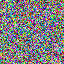

In [101]:
from torchvision import transforms
to_pil = transforms.ToPILImage()
to_pil(t.randn(3,64,64))

`torchvision`提供2个函数，一个是`make_grid`，能将多张图片拼接在一个网格中；另一个是`save_img`，能将Tensor保存成图片。

In [102]:
len(dataset)

10000

In [119]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)
from torchvision.utils import make_grid, save_image
dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0], 4) # 拼成4*4网格图片，且会转成３通道
to_img(img)

ValueError: empty range for randrange() (0,-195, -195)

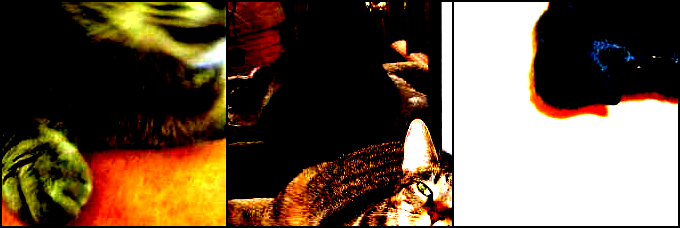

In [113]:
save_image(img,'a.png')
Image.open('a.png')

### 可视化工具

* tensorboard

In [3]:
from tensorboard_logger import Logger

In [4]:
logger = Logger(logdir='experimient_cnn',flush_secs=2)

In [5]:
for ii in range(100):
    logger.log_value('loss',10-ii **0.5,step=ii)
    logger.log_value('accuracy',ii**0.5/10)

* 启动tensorboard

`tensorboard --logdir <log地址>`

* visdom

安装：
> pip install visdom

> python -m visdom.server # 启动visdom

In [12]:
import visdom
import torch as t
#新建一个连接客户端
vis = visdom.Visdom(env = u'test1')# 构建一个客户端，指定env，host,port
x = t.arange(1,30,0.01)
y = t.sin(x)
vis.line(X = x,Y = y,win='sinx',opts = {'title': 'y=sin(x)'})

Setting up a new session...


'sinx'

vis可以使用

`line`：绘制曲线

`image`：可视化图片

`text`：记录日志

`histgram`：可视化分布

`scatter`：绘制散点图

`bar`：柱状图

`pie`：饼状图

visdom支持`tensor`和`numpy的ndarray`，但不支持`int`和`float`，每次需把数据转换成`tensor`或者`ndarray`。

win：用于指定pane的名字，如果两次的win名字一样，则会覆盖。

opts：可视化配置，接收一个字典，包括title,xlabel,ylabel,width。

In [22]:
for ii in range(0,10):
    x = t.Tensor([ii])
    y = x
    vis.line(X = x,Y = y,win='polynomial',update='append' if ii > 0 else None)
    
x = t.arange(0,9,0.1)
y = (x **2) / 9
vis.line(X = x,Y = y,win = 'polynomial',name = 'this is a new Trace')

'polynomial'

In [23]:
#可视化一张黑白照片
vis.image(t.randn(64,64).numpy())

#可视化一张彩色照片
vis.image(t.randn(3,64,64).numpy(),win='random2')

#可视化36张彩色图片，每一行6张
vis.images(t.randn(36,3,64,64).numpy(),nrow=6,win='random3',opts={'title':'random_imgs'})

'random3'

In [29]:
vis.text(u'''<h1>Hello visdom</h1><br>visdom是Facebook<b>PyTorch</b>开发的工具,
    在内部使用''',
        win='visdom',
         opts={'title':u'visdom简介'}
        )

'visdom'